In [1]:
# Set root directory as working directory
import os
os.chdir('../')

In [2]:
import json
import numpy as np
import pandas as pd
from scipy.stats import gamma
from matplotlib import pyplot as plt

# Data preprocessing

In [3]:
data = pd.read_csv('data/raw/casos_hosp_uci_def_sexo_edad_provres.csv')
data = data.groupby(['grupo_edad', 'fecha'], as_index=False)['num_casos'].sum()
data = data.pivot_table(values='num_casos', index='fecha', columns='grupo_edad')
data = data.reset_index()
data['fecha'] = pd.to_datetime(data['fecha'])
data = data.drop(columns=['NC'])
data = data.rename_axis(None, axis=1)
data

,fecha,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,2020-01-01,0,0,0,0,0,0,0,0,0
1,2020-01-02,0,0,0,0,0,0,0,0,0
2,2020-01-03,0,0,0,0,0,0,0,0,0
3,2020-01-04,0,0,0,0,0,0,0,0,0
4,2020-01-05,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
812,2022-03-23,1196,2424,2639,3793,4455,3144,2324,1782,1372
813,2022-03-24,984,1830,1947,2993,3697,2683,1990,1691,1213
814,2022-03-25,982,1587,1673,2588,3248,2547,1858,1698,1289
815,2022-03-26,437,777,648,1187,1565,1162,1048,903,701


In [4]:
# Wave definition (Informe nº 162. Situación de COVID-19 en España.)
waves_date = [
    (data['fecha'] <= pd.to_datetime('2020-06-21')),
    (data['fecha'] > pd.to_datetime('2020-06-21')) & (data['fecha'] <= pd.to_datetime('2020-12-06')),
    (data['fecha'] > pd.to_datetime('2020-12-06')) & (data['fecha'] <= pd.to_datetime('2021-03-14')),
    (data['fecha'] > pd.to_datetime('2021-03-14')) & (data['fecha'] <= pd.to_datetime('2021-06-19')),
    (data['fecha'] > pd.to_datetime('2021-06-19')) & (data['fecha'] <= pd.to_datetime('2021-10-13')),
    (data['fecha'] > pd.to_datetime('2021-10-13')) & (data['fecha'] <= pd.to_datetime('2022-03-27'))
]

waves_name = ['wave_1', 'wave_2', 'wave_3', 'wave_4', 'wave_5', 'wave_6']

data['wave'] = np.select(waves_date, waves_name)
data

,fecha,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+,wave
0,2020-01-01,0,0,0,0,0,0,0,0,0,wave_1
1,2020-01-02,0,0,0,0,0,0,0,0,0,wave_1
2,2020-01-03,0,0,0,0,0,0,0,0,0,wave_1
3,2020-01-04,0,0,0,0,0,0,0,0,0,wave_1
4,2020-01-05,0,0,0,0,0,0,0,0,0,wave_1
...,...,...,...,...,...,...,...,...,...,...,...
812,2022-03-23,1196,2424,2639,3793,4455,3144,2324,1782,1372,wave_6
813,2022-03-24,984,1830,1947,2993,3697,2683,1990,1691,1213,wave_6
814,2022-03-25,982,1587,1673,2588,3248,2547,1858,1698,1289,wave_6
815,2022-03-26,437,777,648,1187,1565,1162,1048,903,701,wave_6


In [5]:
# Output
data.to_csv('data/cases_age_wave.csv', index=False)

# Generation Time

We probably need to use different generation times depending on the specific variant. According to the information from the [Ministry of Health](https://www.sanidad.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/COVID19_Actualizacion_variantes_20230116.pdf), the variant associated to the current classification would be:

- Wave 2 (Jul 2020 - Dec 2020)): ancestral strain
- Wave 3 (Dec 2020 - Feb 2021): ancestral strain, with some presence of the alpha variant from February on
- Wave 4 (Jul 2021 - Sep 2021): delta variant
- Wave 5 (Dec 2021 - March 2022): omicron variant 

Even though the [official waves](https://www.isciii.es/QueHacemos/Servicios/VigilanciaSaludPublicaRENAVE/EnfermedadesTransmisibles/Documents/INFORMES/Informes%20COVID-19/INFORMES%20COVID-19%202023/Informe%20n%C2%BA%20162%20Situaci%C3%B3n%20actual%20de%20COVID-19%20en%20Espa%C3%B1a%20a%205%20de%20enero%20de%202023.pdf) are:

- Wave 1: Feb 2020 - Jun 2020 (ancestral)
- Wave 2: Jun 2020 - Dec 2020 (ancestral)
- Wave 3: Dec 2020 - Mar 2021 (ancestral + alpha from February on)
- Wave 4: Mar 2021 - Jul 2021 (alpha)
- Wave 5: Jul 2021 - Oct 2021 (delta)
- Wave 6: Oct 2021 - Feb 2022 (omicron)

Now, the proper way of weighting this would be to use the generation time. It is true it can be approximated using the serial interval, which is easier to estimate (see [Britton et al.](https://royalsocietypublishing.org/doi/10.1098/rsif.2018.0670) and [Nash et al.](https://journals.plos.org/digitalhealth/article?id=10.1371/journal.pdig.0000052)). But since it is already available, we will use the generation time. Note that we also assume that the incubation period is constant, since technically we should use the infection time and not the date of symptom onset, but this is considered [a good approximation](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008409).

According to [Manica et al.]() the generation time is given by a gamma distribution parametrized as:

- [Ancestral](https://doi.org/10.1016/j.epidem.2021.100528): shape = 1.87, rate = 0.27 (actually is the SI, and in the main text is wrong, see SM)
- [Alpha](https://doi.org/10.1017/S0950268822001947): shape = 2.53, scale = 2.83
- [Delta](https://doi.org/10.1017/S0950268822001947): shape = 2.49, scale = 2.63
- [Omicron](https://doi.org/10.1016/j.lanepe.2022.100446): shape = 2.39, scale = 2.95

mean GT = 6.354615020301237


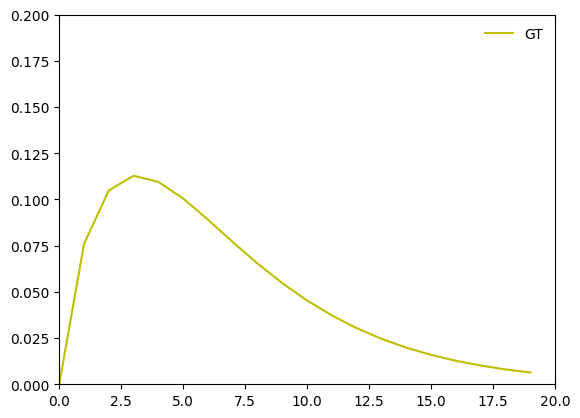

In [6]:
from utils import get_generation_time

x, y = get_generation_time('ancestral')

print(f'mean GT = {np.sum(y*x)}')

fix, ax = plt.subplots(1, 1)
ax.plot(x, y, "y-", label=('GT'))
ax.legend(loc='best', frameon=False, ncol=2)

plt.ylim([0, 0.2])
plt.xlim([0, 20])
plt.show()

# Note that in Tiago's code the first 10 elements are taken, 
# but these come from 50 points equally spaced between 0 and 20
# so they actually represent just 4 days of data, which is wrong
# In this case we use a space of 1, so that X means X days
# Besides, we need to renormalize so that the sum is equal to 1
_, w_gt = get_generation_time('ancestral')

# Aggregate timeseries

In [7]:
max_backwards = 20

_, w_gt = get_generation_time('ancestral', max_backwards)

data_agg = data.copy()
for col in ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]:
    data_agg[col] = data[col].rolling(max_backwards).apply(lambda x: (x * w_gt[::-1]).sum())

data_agg

,fecha,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+,wave
0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wave_1
1,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wave_1
2,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wave_1
3,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wave_1
4,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wave_1
...,...,...,...,...,...,...,...,...,...,...,...
812,2022-03-23,1049.717791,1902.362407,1705.668406,2529.327324,3202.219149,2397.238446,1739.775858,1406.769069,1135.588152,wave_6
813,2022-03-24,1073.589793,1965.810421,1803.341366,2683.782876,3365.949327,2503.508016,1820.039077,1464.087249,1174.335180,wave_6
814,2022-03-25,1080.810916,1991.840783,1866.295655,2788.785777,3478.462059,2574.880159,1875.885862,1512.419898,1198.347277,wave_6
815,2022-03-26,1078.497976,1977.631236,1886.514685,2831.174058,3522.600805,2612.512916,1905.901777,1553.231894,1219.970391,wave_6


In [8]:
data.to_csv('data/cases_age_wave_GT.csv', index=False)